#Data Preperation and Analysis

### Importing Packages

In [93]:
%%capture
!pip install darts 

In [94]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel 
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality ,plot_acf,stationarity_test_adf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression,GaussianLikelihood
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

### DataSet

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
path = '/content/drive/My Drive/TFT_files/output.csv'
df4 = pd.read_csv(path)

In [97]:
df4

,time,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,gen_hyd_pump
0,2014-12-31 23:00:00+00:00,65.41,50.10,"4,821.00","4,844.00","25,385.00",329.00,162.00,73.00,"1,035.00",863.00
1,2015-01-01 00:00:00+00:00,64.92,48.10,"4,755.00","5,196.00","24,382.00",328.00,158.00,71.00,"1,035.00",920.00
2,2015-01-01 01:00:00+00:00,64.48,47.33,"4,581.00","4,857.00","22,734.00",323.00,157.00,73.00,"1,036.00","1,164.00"
3,2015-01-01 02:00:00+00:00,59.32,42.27,"4,131.00","4,314.00","21,286.00",254.00,160.00,75.00,"1,036.00","1,503.00"
4,2015-01-01 03:00:00+00:00,56.04,38.41,"3,840.00","4,130.00","20,264.00",187.00,156.00,74.00,"1,036.00","1,826.00"
...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,77.02,68.85,"2,628.00","7,634.00","30,653.00",0.00,178.00,95.00,"1,027.00",1.00
35060,2018-12-31 19:00:00+00:00,76.16,68.40,"2,566.00","7,241.00","29,735.00",0.00,174.00,95.00,"1,027.00",1.00
35061,2018-12-31 20:00:00+00:00,74.30,66.88,"2,422.00","7,025.00","28,071.00",0.00,168.00,94.00,"1,028.00",50.00
35062,2018-12-31 21:00:00+00:00,69.89,63.93,"2,293.00","6,562.00","25,801.00",0.00,163.00,93.00,"1,028.00",108.00


In [98]:
# datetime
df4["time"] = pd.to_datetime(df4["time"], utc=True, infer_datetime_format=True)
df4.set_index("time", inplace=True)

In [99]:
f64cols = list(df4.dtypes[df4.dtypes == np.float64].index)
df4[f64cols] = df4[f64cols].applymap(np.float32)

In [100]:
df4 = df4[df4.index >= "2018-01-01 00:00:00+00:00"]

In [101]:
print(len(df4))

8759


In [102]:
fig = px.line(df4, x=df4.index, y='price', title='Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Conversion to TimeSeries

In [103]:
# create time series object for target variable
price = TimeSeries.from_series(df4["price"]) 

# check attributes of the time series
print("components:", price.components)
print("duration:",price.duration)
print("frequency:",price.freq)
print("frequency:",price.freq_str)
print("has date time index? (or else, it must have an integer index):",price.has_datetime_index)
print("deterministic:",price.is_deterministic)
print("univariate:",price.is_univariate)

components: Index(['price'], dtype='object', name='component')
duration: 364 days 22:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [104]:
len(price)

8759

In [105]:
def plotsignal(ts,title_name):

  #Creating datafram from Timeseries
  cc=ts.pd_dataframe()

  fig = go.Figure([go.Scatter(x=cc.index, y=cc.iloc[:,0],name='Prediction')])
  fig.update_xaxes(rangeslider_visible=True)
  fig.update_layout(title_text = title_name)
  fig.update_xaxes(title_text="Time")
  fig.update_yaxes(title_text="Price")
  return fig.show()

In [106]:
plotsignal(price,'TimeSeries')

###Seasonality Check

In [107]:
MSEAS = 200
ALPHA = 0.05
mseas=MSEAS
seasonality = []
for m in range(2, MSEAS):
    is_seasonal, mseas = check_seasonality(price, m=m, alpha=ALPHA, max_lag=MSEAS)
    if is_seasonal:
       seasonality.append(mseas)
      #  break
print(seasonality)
print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {} hours'.format(mseas))

[11, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192]
seasonal? False


Trend and seasonal components

In [108]:
trend, seas = extract_trend_and_seasonality(ts=price, freq=168)
plotsignal(trend,'Trend Component')

In [109]:
plotsignal(seas,"seasonal component")

### Covariates

In [110]:
# create time series object for the feature columns
df_cov = df4.loc[:, df4.columns != "price"]
covariates = TimeSeries.from_dataframe(df_cov)

In [111]:
covariates.columns

Index(['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual', 'gen_lig',
       'gen_oil', 'gen_oth_renew', 'pressure_Barcelona', 'gen_hyd_pump'],
      dtype='object', name='component')

In [112]:
covariates.n_components

9

In [113]:
# rescale the covariates: fit on the training set
scaler = Scaler()
scaler.fit(covariates)
covariates = scaler.transform(covariates)

In [114]:
len(covariates)

8759

In [115]:
covariates.pd_dataframe().iloc[[0,-1]]

component,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,gen_hyd_pump
time,,,,,,,,,
2018-01-01 00:00:00,0.03,0.04,0.25,0.17,0.00,0.46,0.63,0.59,0.50
2018-12-31 22:00:00,0.76,0.24,0.52,0.28,0.00,0.37,0.77,0.82,0.03


In [116]:
# you will need more data for past covariates if forcast horizon(n) > output_chunk_length
# links to clarify:
# https://unit8co.github.io/darts/userguide/covariates.html  after reading this go for the below link for more in-depft Knowledge
# https://unit8co.github.io/darts/userguide/torch_forecasting_models.html


In [117]:
# cov_fut = covariates.concatenate(   other=covariates.tail(size=24), 
#                                     ignore_time_axis=True)

In [118]:
#cov_fut.pd_dataframe().iloc[[0,-1]]

### Train/Test Split (Target Variable)

In [119]:
target_train, target_test = price.split_after(0.9)
print("training start:", target_train.start_time())
print("training end:", target_train.end_time())
print("training duration:",target_train.duration)
print("test start:", target_test.start_time())
print("test end:", target_test.end_time())
print("test duration:", target_test.duration)

training start: 2018-01-01 00:00:00
training end: 2018-11-25 10:00:00
training duration: 328 days 10:00:00
test start: 2018-11-25 11:00:00
test end: 2018-12-31 22:00:00
test duration: 36 days 11:00:00


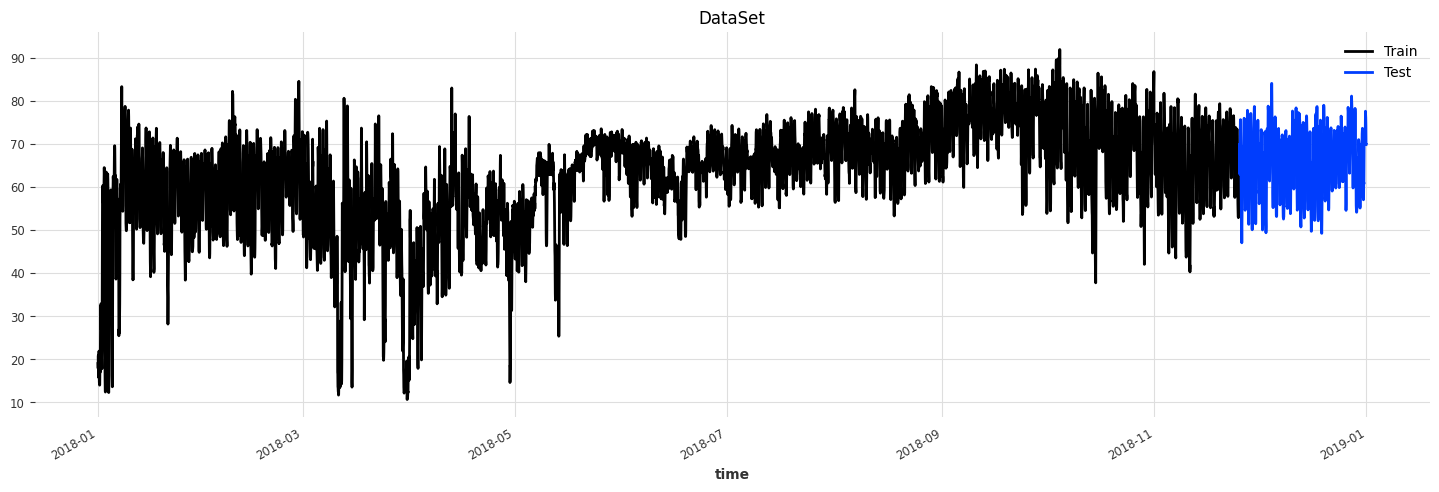

In [120]:
plt.figure(100, figsize=(18, 5))
target_train.plot(label="Train")
target_test.plot(label="Test")
plt.title("DataSet");

### Scaling (Between 0 and 1)

In [121]:
scalerPrice = Scaler()
scalerPrice.fit(target_train)
trans_target_train = scalerPrice.transform(target_train)
trans_target_test = scalerPrice.transform(target_test)    
trans_price = scalerPrice.transform(price)

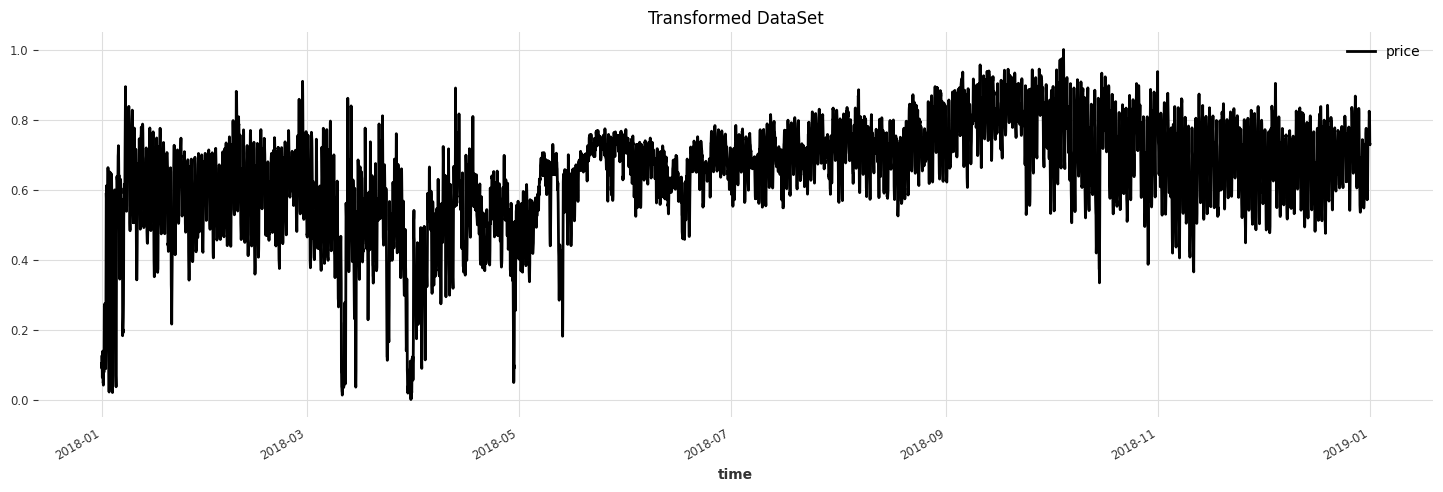

In [122]:
plt.figure(100, figsize=(18, 5))
trans_price.plot()
plt.title("Transformed DataSet");

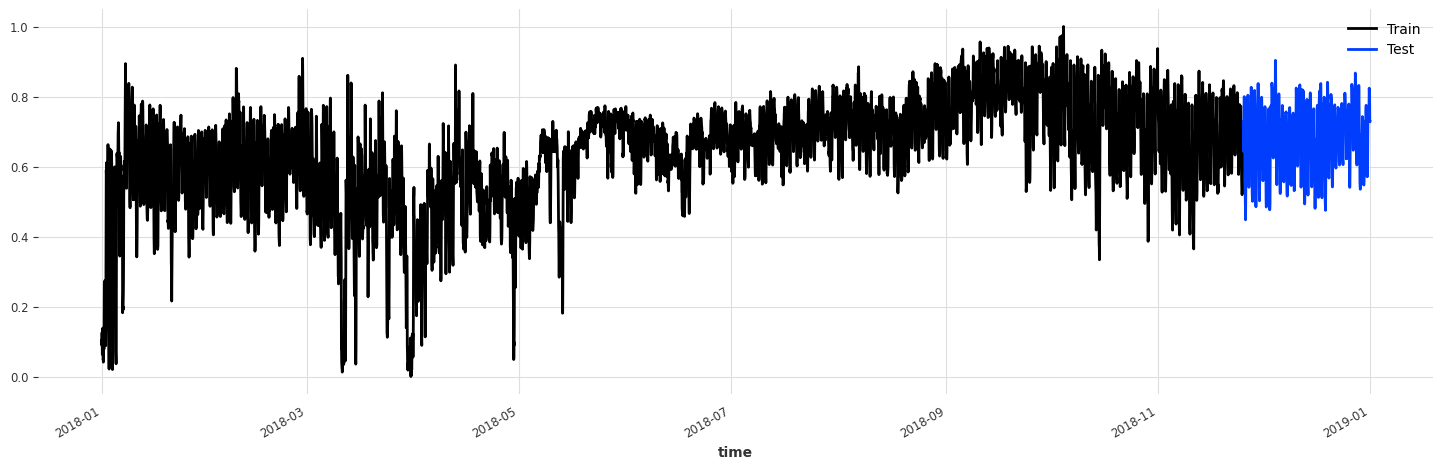

In [123]:
plt.figure(100, figsize=(18, 5))
trans_target_train.plot(label="Train")
trans_target_test.plot(label="Test")

In [124]:
# Spliting the train dataset into final_train and validation set
final_train , final_val = trans_target_train.split_after(0.8)
print("training start:", final_train.start_time())
print("training end:", final_train.end_time())
print("training duration:",final_train.duration)
print("Validation start:", final_val.start_time())
print("Validation end:", final_val.end_time())
print("Validation duration:", final_val.duration)

training start: 2018-01-01 00:00:00
training end: 2018-09-20 17:00:00
training duration: 262 days 17:00:00
Validation start: 2018-09-20 18:00:00
Validation end: 2018-11-25 10:00:00
Validation duration: 65 days 16:00:00


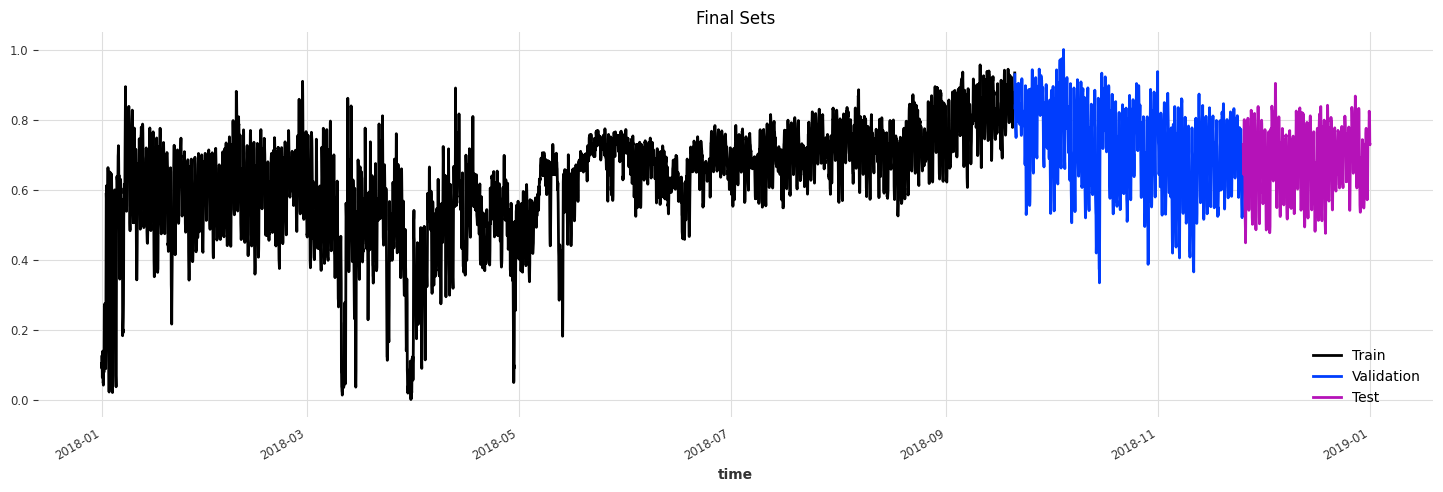

In [125]:
plt.figure(100, figsize=(18, 5))
final_train.plot(label="Train")
final_val.plot(label = 'Validation')
trans_target_test.plot(label="Test")
plt.title("Final Sets");

#NBEATS Model

### Instantiating

In [126]:
BEATS = NBEATSModel(
    input_chunk_length=168, 
    output_chunk_length=24,
    generic_architecture=True,
    log_tensorboard =True,
    random_state=42)


### Training

In [127]:
BEATS.fit(
    final_train,
    past_covariates= covariates,
    epochs=2
)

Training: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, log_tensorboard=True, random_state=42)

### Predicting

In [128]:
# testing: generate predictions
predicted_horizon = BEATS.predict( n=len(final_val), 
                                   series = final_train,
                                   past_covariates=covariates,
                                   verbose=True
                                 )

Predicting: 0it [00:00, ?it/s]

## Ploting Code

In [129]:
def plotit(act_ts,pred_ts,title_name):

  #Creating datafram from Timeseries
  cc=pred_ts.pd_dataframe()
  c1 = act_ts.pd_dataframe()

  fig = go.Figure([go.Scatter(x=cc.index, y=cc.price,name='Prediction'),go.Scatter(x=c1.index, y=c1.price,name='Actual')])
  fig.update_xaxes(rangeslider_visible=True)
  fig.update_layout(title_text = f"{title_name} \t Mape : {mape(act_ts,pred_ts)}")
  fig.update_xaxes(title_text="Time")
  fig.update_yaxes(title_text="Price")
  return fig.show()

## Validation Set Analysis

In [130]:
# scaled values

In [131]:
print(mape(final_val,predicted_horizon))

37.583351135253906


In [132]:
plotit(final_val,predicted_horizon,'Validation Set')

In [133]:
# Transforming the data back to original scale

In [134]:
val = scalerPrice.inverse_transform(final_val)
horizon = scalerPrice.inverse_transform(predicted_horizon)
#print(mape(val,horizon))

In [135]:
plotit(val,horizon,'Validation Set')

#Tunning

##Optuna 

### Importing Packages

In [ ]:
%%capture
!pip install -U optuna

In [ ]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
import torch
import random
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

### Objective function

In [ ]:
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
    
    # reproducibility
    torch.manual_seed(42)

    # set input_chunk_length, between 5 and 14 days
    days_in = trial.suggest_int("days_in", 3, 28)
    in_len = days_in * 24

    # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    days_out = trial.suggest_int("days_out", 1, days_in - 1)
    out_len = days_out *24

    # Other hyperparameters
    #hidden_size = trial.suggest_categorical("hidden_size", [32,64,128,256])
    batch_size = trial.suggest_categorical("batch_size", [32,64,128,256])
    #weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    # num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    # dropout = trial.suggest_float("dropout", 0.0, 0.4)
    # lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    #include_dayofweek = trial.suggest_categorical("dayofweek", [False, True])
    
    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
 
    callbacks = [early_stopper] + callback

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": -1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 4
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # build and train the NBEATS model with these hyper-parameters:
    BEATS = NBEATSModel(  input_chunk_length=in_len, 
                          output_chunk_length=out_len,
                          batch_size = batch_size,
                          pl_trainer_kwargs= pl_trainer_kwargs,
                          generic_architecture=True,
                          random_state=42
                       )
    model_val_set = price[(final_val.start_time()-pd.Timedelta(in_len, unit=price.freq_str)  ):(final_val.end_time())]

    BEATS.fit(final_train,
              past_covariates= covariates,
              val_series=model_val_set,
              val_past_covariates = covariates,
              epochs=2
             )
    # testing: generate predictions
    # testing: generate predictions
    predicted_horizon = BEATS.predict( n=len(final_val), 
                                       series = final_train,
                                       past_covariates=covariates,
                                       verbose=True
                                 )
    # Evaluate how good it is on the validation set
    
    mape_val = mape(final_val, predicted_horizon, n_jobs=-1, verbose=True)


    return mape_val if mape_val != np.nan else float("inf")

### Study Optimization

In [ ]:

# def print_callback(study, trial):
#     print(f"Current value: {trial.value}, Current params: {trial.params}")
#     print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

%%capture
study = optuna.create_study(direction="minimize")

#study.optimize(objective, timeout=300, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
study.optimize(objective, n_trials=5)#, callbacks=[print_callback])

### Best Parameters

In [ ]:
# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

Best value: 32.395774126052856, Best params: {'days_in': 7, 'days_out': 2, 'batch_size': 128}


#After Model Tunning

### Instantiating

In [136]:
BEATS = NBEATSModel(
    input_chunk_length=7*24, 
    output_chunk_length=2*24,
    batch_size = 128,
    generic_architecture=True,
    log_tensorboard =True,
    random_state=42)


### Training

In [137]:
BEATS.fit(
    final_train,
    past_covariates= covariates,
    val_series=final_val,
    val_past_covariates = covariates,
    epochs=2
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=48, batch_size=128, log_tensorboard=True, random_state=42)

## Validation Set Analysis

###Prediction

In [138]:
# testing: generate predictions
predicted_horizon = BEATS.predict( n=len(final_val), 
                                   series = final_train,
                                   past_covariates=covariates,
                                   verbose=True
                                 )

Predicting: 0it [00:00, ?it/s]

### Scaled Values




In [139]:
plotit(final_val,predicted_horizon,'Validation Set')

### Original Values

In [140]:
# Transforming back to original scale
val = scalerPrice.inverse_transform(final_val)
horizon = scalerPrice.inverse_transform(predicted_horizon)
#print(mape(val,horizon))

In [141]:
plotit(val,horizon,'Validation Set')

## Test Set Analysis

### Prediction

In [142]:
#generate predictions
predicted_horizon = BEATS.predict( n=len(trans_target_test), 
                                   series = trans_target_train,
                                   past_covariates=covariates,
                                   verbose=True
                                 )

Predicting: 0it [00:00, ?it/s]

### Scaled Values




In [143]:
plotit(trans_target_test,predicted_horizon,'Test Set')

### Original Values

In [144]:
# Transforming the data back to original scale
Test = scalerPrice.inverse_transform(trans_target_test)
horizon = scalerPrice.inverse_transform(predicted_horizon)

In [145]:
plotit(Test,horizon,'Test Set')

## Predict the Future: Out of Sample 

### Prediction

In [146]:
days = 30
# Adding covariates for required days
cov_fut = covariates.concatenate(   other=covariates.tail(size=24*days), 
                                    ignore_time_axis=True)

#generate predictions
predicted_horizon = BEATS.predict( n= days*24, 
                                   series = trans_price,
                                   past_covariates=cov_fut,
                                   verbose=True
                                 )

Predicting: 0it [00:00, ?it/s]

### Scaled Values




In [147]:
plotit(trans_price.tail(days*24),predicted_horizon,f'Future Prediction for {days} days')

### Original Values

In [148]:
# Transforming the data back to original scale
horizon = scalerPrice.inverse_transform(predicted_horizon)

In [149]:
plotit(price.tail(days*24),horizon,'Future prediction')